In [0]:
from bs4 import BeautifulSoup
import re, requests, csv, time


bs4 used for scraping the data, 
requests used for acquring the specific url,
csv used for reading and opening the csv,
time used for sleep timer.

In [0]:
channel_name = "zacefroncom"

In [0]:
def get_soup(url):
    result = requests.get(url)
    if result.status_code != 200: return None
    time.sleep(5)
    return BeautifulSoup(result.text, 'html.parser')

In [0]:
def channel_section_links():
    soup = get_soup(f"https://www.youtube.com/user/{channel_name}/playlists")
    if 'This channel does not exist.' in soup.text:
        raise ValueError("The channel does not exists: " + channel_name)
    play_list_atags = soup.find_all('a', {'href': re.compile(f"{channel_name}/playlists")})
    elements = [{'title': x.text.strip(), "link": fix_url(x['href'])} for x in play_list_atags if
                x.span and ('shelf_id=0' not in x['href'])] 
    if len(elements) == 0: 
        elements = [ {'title':'no sections',
                      'link':f'https://youtube.com/{channel_name}/playlists'}]

    return elements

In [0]:
def fix_url(url):  
    if url[0] == '/': return 'https://www.youtube.com' + url
    else: return url


In [0]:
def get_playlists(section):
    print(f"  getting playlists for section: {section['title']}")
    soup = get_soup(section['link'])
    if soup == None: 
       return [{'title':'No Playlists', 'link':f'https://youtube.com/{channel_name}/videos'}]
    atags = soup('a', class_="yt-uix-tile-link")
    playlists = []
    for a in atags:
        title = a.text
        if title != "Liked videos": 
            link = fix_url(a['href'])
            playlists.append({'title':title, 'link':link})
    if playlists == []: return [{'title':'No Playlists',
                                 'link':f'https://youtube.com/{channel_name}/videos'}]
    return playlists

In [0]:
def add_videos(playlist):
    soup = get_soup(playlist['link'])
    print(f"    getting videos for playlist: {playlist['title']}")
    items = soup('a', class_="yt-uix-tile-link")
    videos = []
    for i in items: 
        d = {} 
        d['title'] = i.text.strip()
        link = fix_url(i['href'])
        d['link'] = link
        t = i.find_next('span', { 'aria-label': True})
        d['time'] = t.text if t else 'NA'
        print(f"      open video '{d['title']}' for details", end=" ")

        vsoup = get_soup(link) 
        print("* read, now processing",end="")
        views= vsoup.find('div', class_='watch-view-count').text
        d['views'] = ''.join(c for c in views if c in "0123456789")
        d['publication_date'] = vsoup.find('strong',
                                class_="watch-time-text").text[len('Published on ')-1:]
        d['description'] = vsoup.find('div',id='watch-description-text').text
        id = vsoup.find('meta', itemprop="videoId")['content']
        d['short_link'] = f'https://youtu.be/{id}'
        likebutton = vsoup.find('button', class_="like-button-renderer-like-button")
        d['likes'] = likebutton.find('span',class_ = 'yt-uix-button-content').text
        disbutton = vsoup.find('button',class_='like-button-renderer-dislike-button')
        d['dislikes'] = disbutton.find('span',class_ = 'yt-uix-button-content').text
        videos.append(d)
        print("* finished video")

        playlist['videos'] = videos 


In [0]:
def tag(t,c): return f'<{t}>{c}</{t}>' 
def link(text, url): return f'{text}' 

In [0]:
def html_out(channel, sections):
    title = f"YouTube Channel {channel}"
    f = open(f"{channel}.html",'w')
    template = '\n\n\n' + \
    '\n\n\n{}\n\n'

    parts = []
    parts.append(tag('h1', title))

    for section in sections:
        parts.append(tag('h2',link(section['title'], section['link'])))
        for playlist in section['playlists']:
            parts.append(tag('h3',link(playlist['title'], playlist['link'])))
            parts.append('')
            for video in playlist['videos']:
                parts.append(tag('li',link(video['title'], video['short_link']) \
                                 + ' (' + video['time'] + ")"))
            parts.append('')
    f.write(template.format(channel, '\n'.join(parts)))
    f.close()

In [0]:
def csv_out(channel, sections):
    headers = 'channel,section,playlist,video,' \
              'link,time,views,publication date,likes,dislikes,description'.split(',')

    with open(f'{channel}.csv', "w") as csv_file:
        csvf = csv.writer(csv_file, delimiter=',')
        csvf.writerow(headers)
        for section in sections:
            for playlist in section['playlists']:
                for video in playlist['videos']:
                    v = video
                    line = [ channel, section['title'], playlist['title'], v['title']]
                    line.extend([v['short_link'],v['time'], v['views'], v['publication_date'],
                                 v['likes'], v['dislikes'], v['description']])
                    csvf.writerow(line)

In [28]:
if __name__ == '__main__':

    print("finding sections")
    sections = channel_section_links()
    for section in sections:
        section['playlists'] = get_playlists(section)
        for playlist in section['playlists']:
            add_videos(playlist)

    html_out(channel_name, sections) 
    csv_out(channel_name, sections)

    print(f"Program Complete,\n  '{channel_name}.htm' and" \
          f" '{channel_name}.csv' have been written to current directory")

finding sections
  getting playlists for section: no sections
    getting videos for playlist: Gym Time w/ Zac Efron
      open video 'DUDE PERFECT takes over Gym Time | Gym Time w/ Zac Efron' for details * read, now processing* finished video
      open video 'LIZA KOSHY Is My New Workout Buddy | Gym Time w/ Zac Efron' for details * read, now processing* finished video
      open video 'Juju Smith-Schuster Smoked This NFL Workout | Gym Time w/ Zac Efron' for details * read, now processing* finished video
      open video 'Baywatch Abs with Alexandra Daddario | Gym Time w/ Zac Efron' for details * read, now processing* finished video
      open video 'Earning My Victoria’s Secret Angel Wings | Gym Time w/ Zac Efron' for details * read, now processing* finished video
      open video 'My Chest and Back Day Workout With Actor Geoff Stults | Gym Time w/ Zac Efron' for details * read, now processing* finished video
      open video 'I Train with NFL Great Marcedes Lewis | Gym Time w/ Zac E

In [0]:
import pandas as pd
data = pd.read_csv('/content/zacefroncom.csv')

In [48]:
data

,channel,section,playlist,video,link,time,views,publication date,likes,dislikes,description
0,zacefroncom,no sections,Gym Time w/ Zac Efron,DUDE PERFECT takes over Gym Time | Gym Time w/...,https://youtu.be/lLSDe9Oyk9Q,8:41,NaN,"Nov 26, 2019","55,054",690,"If you watch Dude Perfect, you know that these..."
1,zacefroncom,no sections,Gym Time w/ Zac Efron,LIZA KOSHY Is My New Workout Buddy | Gym Time ...,https://youtu.be/dTjUL22bwLE,8:41,NaN,"Nov 19, 2019","103,736",955,"Liza Koshy is an incredibly inspiring creator,..."
2,zacefroncom,no sections,Gym Time w/ Zac Efron,Juju Smith-Schuster Smoked This NFL Workout | ...,https://youtu.be/BifAFA-g9HE,7:51,NaN,"Aug 29, 2019","21,067",166,Hitting the gym with Juju Smith-Schuster. My t...
3,zacefroncom,no sections,Gym Time w/ Zac Efron,Baywatch Abs with Alexandra Daddario | Gym Tim...,https://youtu.be/1wJLKKZMxPc,8:58,NaN,"Jul 9, 2019","203,221","2,536",My Baywatch co-star Alexandra Daddario joins m...
4,zacefroncom,no sections,Gym Time w/ Zac Efron,Earning My Victoria’s Secret Angel Wings | Gym...,https://youtu.be/58zE0ld6Njw,6:34,NaN,"May 28, 2019","81,014",696,I wondered what it must take to get a Victoria...
5,zacefroncom,no sections,Gym Time w/ Zac Efron,My Chest and Back Day Workout With Actor Geoff...,https://youtu.be/kZ4lz_2d-5k,8:48,NaN,"Apr 26, 2019","19,325",132,"This Gym Time I’m joined by friend, actor and ..."
6,zacefroncom,no sections,Gym Time w/ Zac Efron,I Train with NFL Great Marcedes Lewis | Gym Ti...,https://youtu.be/tCFjzDC5T0M,10:23,NaN,"Apr 18, 2019","41,724",251,Watch me take on an NFL training session with ...
7,zacefroncom,no sections,Gym Time w/ Zac Efron,Nina Dobrev Crushes my Workout | Gym Time w/ Z...,https://youtu.be/pR3etHshl8k,9:38,NaN,"Apr 4, 2019","253,137","2,153",Nina Dobrev shares her competitive nature and ...
8,zacefroncom,no sections,Off The Grid w/ Zac Efron,We Spent 96 Hours In The Desert… | Off The Gri...,https://youtu.be/HiSj8lIBK5I,10:58,NaN,"r 30, 2019","53,567",449,Its official guys. I’m on YouTube!SUBSCRIBE fo...
9,zacefroncom,no sections,Off The Grid w/ Zac Efron,How I Tore My ACL Skiing… | Off The Grid w/ Za...,https://youtu.be/AiPXZXd-Hf0,4:21,NaN,"Apr 12, 2019","23,715",124,Dylan and I go cat-skiing outside of Park City...


In [46]:
data[data['likes']==data['likes'].max()]

,channel,section,playlist,video,link,time,views,publication date,likes,dislikes,description
4,zacefroncom,no sections,Gym Time w/ Zac Efron,Earning My Victoria’s Secret Angel Wings | Gym...,https://youtu.be/58zE0ld6Njw,6:34,NaN,"May 28, 2019","81,014",696,I wondered what it must take to get a Victoria...


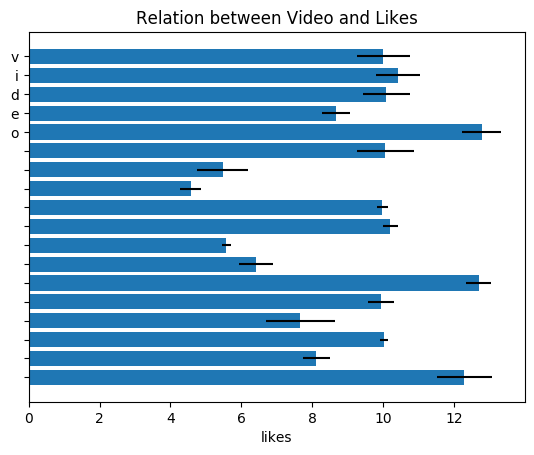

In [88]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcdefaults()
fig, ax = plt.subplots()
import numpy as np
y_pos = np.arange(len(data.likes))
x_pos = 3 + 10 * np.random.rand(len(data.dislikes))
error = np.random.rand(len(data.likes))
ax.barh(y_pos, x_pos, xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels('video')
ax.invert_yaxis()  
ax.set_xlabel('likes')
ax.set_title('Relation between Video and Likes')

plt.show()
